## Importações

In [46]:
import logging
import pandas as pd
import numpy as np
import datetime
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.utils.data.dataset import random_split
import torch.optim as optim
from sklearn.datasets import make_moons
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, precision_recall_curve, auc, accuracy_score, fbeta_score, precision_score, recall_score, classification_report, ConfusionMatrixDisplay, f1_score, RocCurveDisplay, PrecisionRecallDisplay
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.tree import DecisionTreeClassifier
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from imblearn.over_sampling import SMOTE
from google.colab import files

%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
# configure logging
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(message)s",
                    datefmt='%d-%m-%Y %H:%M:%S')

# reference for a logging obj
logger = logging.getLogger()
logger.setLevel(logging.INFO)

## Fetch Data

Baixe o dataset presente em: https://www.kaggle.com/datasets/rabieelkharoua/predict-customer-purchase-behavior-dataset/data

In [3]:
seed_number = 42
data_path = './customer_purchase_data.csv'
df = pd.read_csv(data_path)

### Pre-Processing 1

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1500 entries, 0 to 1499
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Age                 1500 non-null   int64  
 1   Gender              1500 non-null   int64  
 2   AnnualIncome        1500 non-null   float64
 3   NumberOfPurchases   1500 non-null   int64  
 4   ProductCategory     1500 non-null   int64  
 5   TimeSpentOnWebsite  1500 non-null   float64
 6   LoyaltyProgram      1500 non-null   int64  
 7   DiscountsAvailed    1500 non-null   int64  
 8   PurchaseStatus      1500 non-null   int64  
dtypes: float64(2), int64(7)
memory usage: 105.6 KB


In [8]:
# Delete duplicated rows
df.drop_duplicates(inplace=True)
# There are duplicated rows
logging.info(f" Número de linhas repetidas: {df.duplicated().sum()}")
df.shape

INFO:root: Número de linhas repetidas: 0


(1388, 9)

In [9]:
# Alterando nomes das colunas
df.columns = [
    'age',
    'gender',
    'annual_income',
    'number_of_purchases',
    'product_category',
    'time_spent_on_website',
    'loyalty_program',
    'discounts_availed',
    'purchase_status'
]
df.columns

Index(['age', 'gender', 'annual_income', 'number_of_purchases',
       'product_category', 'time_spent_on_website', 'loyalty_program',
       'discounts_availed', 'purchase_status'],
      dtype='object')

In [10]:
# Mapeando valores numéricos para rótulos de categorias de produtos
product_category_values = {
    0: 'electronics',
    1: 'clothing',
    2: 'home_goods',
    3: "beauty",
    4: "sports"
}

df.product_category = df.product_category.map(product_category_values)

In [11]:
df.head()

,age,gender,annual_income,number_of_purchases,product_category,time_spent_on_website,loyalty_program,discounts_availed,purchase_status
0,40,1,66120.267939,8,electronics,30.568601,0,5,1
1,20,1,23579.773583,4,home_goods,38.240097,0,5,0
2,27,1,127821.306432,11,home_goods,31.633212,1,0,1
3,24,1,137798.623120,19,beauty,46.167059,0,4,1
4,31,1,99300.964220,19,clothing,19.823592,0,0,1


### Data Segregation

In [12]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=seed_number)

In [13]:
logger.info(f" df_train: {df_train.shape}")
logger.info(f" df_test: {df_test.shape}")

INFO:root: df_train: (1110, 9)
INFO:root: df_test: (278, 9)


## Treinamento

In [14]:
#Separando característica e variável alvo
X = df_train.drop(columns = 'purchase_status')
y = df_train['purchase_status']

In [15]:
# Separando conjuntos em treino e validação
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=seed_number)

In [16]:
logger.info(f" x train: {X_train.shape}")
logger.info(f" y train: {y_train.shape}")
logger.info(f" x val: {X_val.shape}")
logger.info(f" y val: {y_val.shape}")

INFO:root: x train: (888, 8)
INFO:root: y train: (888,)
INFO:root: x val: (222, 8)
INFO:root: y val: (222,)


Codificação e Normalização

In [17]:
# Define as colunas categóricas e numéricas do dataset
categorical_features = ['gender', 'product_category', 'loyalty_program']
numerical_features = ['age', 'annual_income', 'number_of_purchases', 'time_spent_on_website',  'discounts_availed']

In [18]:
# Cria um pipeline para transformar variáveis categóricas
categorical_pipeline = Pipeline(steps=[
    ('cat_encoder', OneHotEncoder(sparse_output=False, drop='first'))
])

# Cria um pipeline para padronizar variáveis numéricas
numerical_pipeline = Pipeline(steps=[
    ('num_transformer', StandardScaler())
])

In [19]:
# Combina os pipelines categórico e numérico em um único transformador para aplicar as transformações nas colunas
full_pipeline = ColumnTransformer(
  transformers=[
    ('cat', categorical_pipeline, categorical_features),
    ('num', numerical_pipeline, numerical_features)

  ]
)

In [20]:
#Aplica a transformação
X_train = full_pipeline.fit_transform(X_train)
X_val = full_pipeline.transform(X_val)

# Exibir o tamanho dos conjuntos de dados
logger.info(f" x train: {X_train.shape}")
logger.info(f" y train: {y_train.shape}")
logger.info(f" x val: {X_val.shape}")
logger.info(f" y val: {y_val.shape}")

INFO:root: x train: (888, 11)
INFO:root: y train: (888,)
INFO:root: x val: (222, 11)
INFO:root: y val: (222,)


Balanceamento de dados com SMOTE

In [21]:
# Aplica o SMOTE para balancear as classes da base de treino, gerando amostras sintéticas da minoria.
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

PyTorch

In [22]:
# Converte os dados de treino e validação para tensores do PyTorch
x_train_tensor = torch.as_tensor(X_train).float()
y_train_tensor = torch.as_tensor(y_train.values.reshape(-1, 1)).float()

x_val_tensor = torch.as_tensor(X_val).float()
y_val_tensor = torch.as_tensor(y_val.values.reshape(-1, 1)).float()

# Cria datasets do PyTorch a partir dos tensores de treino e validação
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)

# Define os dataloaders para carregar os dados em mini-lotes durante o treinamento e validação
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=64)

In [23]:
class Architecture(object):
    """
    Classe que encapsula a lógica de treinamento, validação e avaliação de um modelo PyTorch
    """
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class

        # We start by storing the arguments as attributes
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None

        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model,
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step_fn = self._make_train_step_fn()
        # Creates the val_step function for our model and loss
        self.val_step_fn = self._make_val_step_fn()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        try:
            self.device = device
            self.model.to(self.device)
        except RuntimeError:
            self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
            print(f"Couldn't send it to {device}, sending it to {self.device} instead.")
            self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def _make_train_step_fn(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer

        # Builds function that performs a step in the train loop
        def perform_train_step_fn(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step_fn

    def _make_val_step_fn(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step_fn(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step_fn

    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step_fn = self.val_step_fn
        else:
            data_loader = self.train_loader
            step_fn = self.train_step_fn

        if data_loader is None:
            return None

        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step_fn(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=seed_number):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=seed_number):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename,weights_only=False)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval()
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

In [123]:
class LogisticRegressionModel(nn.Module):
    """
    Esta classe define uma rede neural para classificação binária.
    """
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 8),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(8, 4),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(4, 1)
        )

    def forward(self, x):
        return self.model(x)

In [124]:
# Cria uma instância do modelo de regressão logística com o número de features de entrada
model = LogisticRegressionModel(X_train.shape[1])

# Define a função de perda para classificação binária com logits
loss_fn = nn.BCEWithLogitsLoss()

# Configura o otimizador Adam para atualizar os pesos do modelo
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

# Inicializa a arquitetura de treinamento
arch = Architecture(model, loss_fn, optimizer)

# Define os dataloaders de treino e validação na arquitetura
arch.set_loaders(train_loader, val_loader)

# 4. Treinamento do modelo
arch.train(n_epochs=100)

### Curva de Perda e Métricas de Desempenho

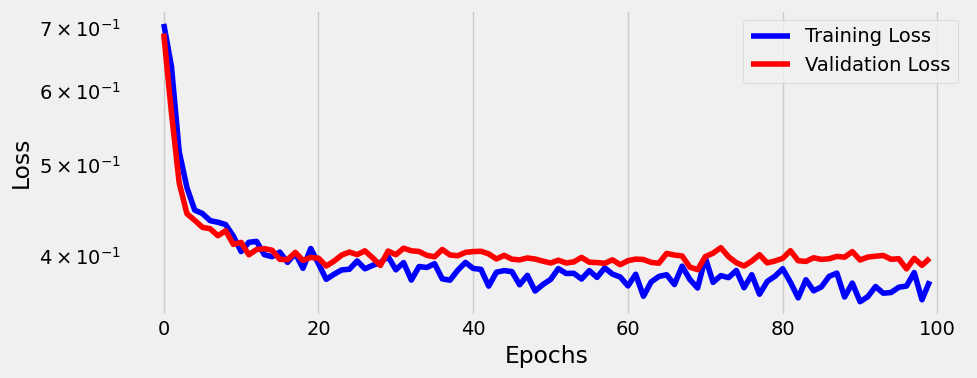

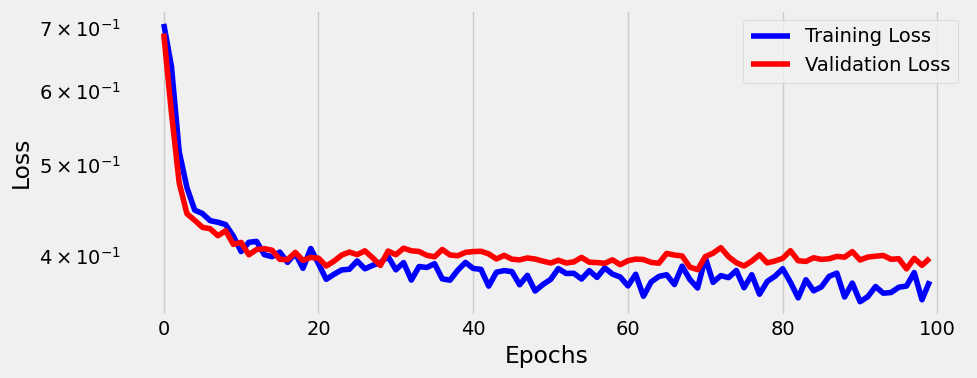

In [125]:
# Plota os valores da perda ao longo das épocas de treino e validação
arch.plot_losses()

In [126]:
# Gera as probabilidades previstas pelo modelo para os dados de validação
y_pred_probs = arch.predict(x_val_tensor)

# Converte as probabilidades em rótulos binários com limiar de 0.5
y_pred_labels = (y_pred_probs >= 0.5).astype(int)

In [127]:
# Converter y_test_tensor para numpy
y_true = y_val_tensor.cpu().numpy()

# Métricas
accuracy = accuracy_score(y_true, y_pred_labels)
precision = precision_score(y_true, y_pred_labels)
recall = recall_score(y_true, y_pred_labels)
f1 = f1_score(y_true, y_pred_labels)

logger.info(f" Accuracy : {accuracy:.4f}")
logger.info(f" Precision: {precision:.4f}")
logger.info(f" Recall   : {recall:.4f}")
logger.info(f" F1 Score : {f1:.4f}")

INFO:root: Accuracy : 0.8514
INFO:root: Precision: 0.8586
INFO:root: Recall   : 0.8173
INFO:root: F1 Score : 0.8374


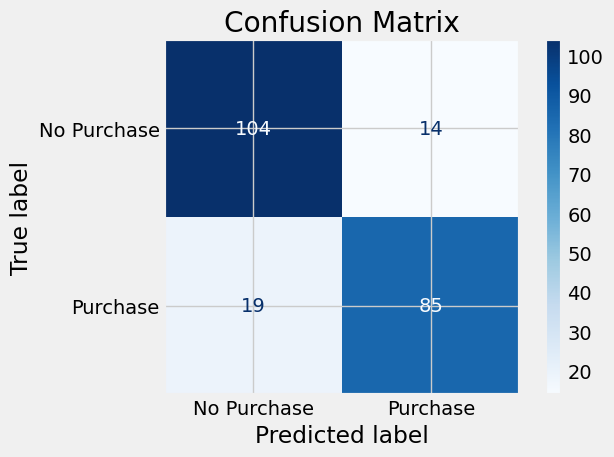

In [128]:
# Matriz de confusão
cm = confusion_matrix(y_true, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["No Purchase", "Purchase"])
disp.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix")
plt.tight_layout()

plt.savefig("confusion_matrix.png", dpi=300)

plt.show()

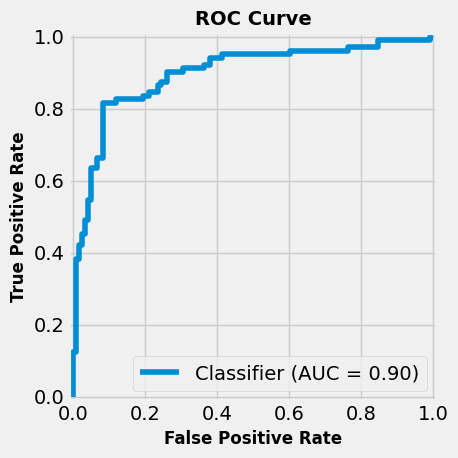

In [131]:
# Gerar a curva ROC
RocCurveDisplay.from_predictions(y_true, y_pred_probs)

plt.title("ROC Curve", fontsize=14, fontweight='bold', color='black')
plt.xlabel("False Positive Rate", fontsize=12, fontweight='bold', color='black')
plt.ylabel("True Positive Rate", fontsize=12, fontweight='bold', color='black')
plt.tight_layout()
# Salvar a figura gerada como um arquivo PNG
plt.savefig("precision_recall_curve.png", dpi=300)
plt.show()

In [134]:
# Calcula a área sob a curva ROC
fpr, tpr, _ = roc_curve(y_true, y_pred_probs)
roc_auc = auc(fpr, tpr)
print(f"AUC: {roc_auc:.4f}")

AUC: 0.8970


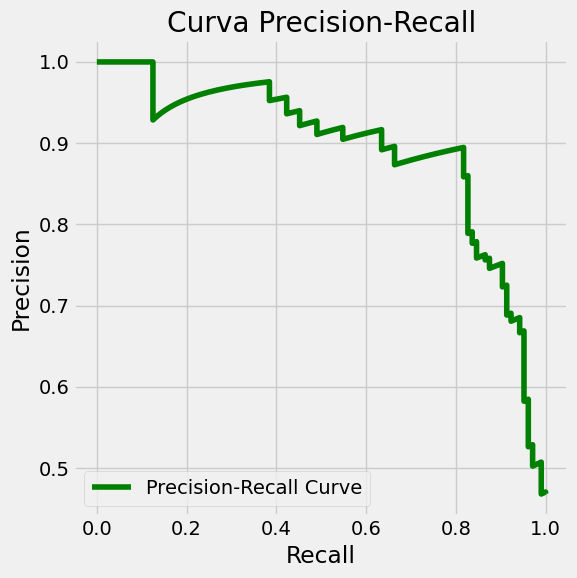

In [133]:
# Calcula os pontos da curva Precision-Recall
prec, rec, _ = precision_recall_curve(y_true, y_pred_probs)

plt.figure(figsize=(6, 6))
plt.plot(rec, prec, color="green", label="Precision-Recall Curve")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Curva Precision-Recall")
plt.grid(True)
plt.legend(loc="lower left")
plt.tight_layout()
# Salvar a figura gerada como um arquivo PNG
plt.savefig("precision_recall_curve.png", dpi=300)
plt.show()

In [67]:
# Calcula a área sob a curva Precision-Recall
pr_auc = auc(rec, prec)
print(f"PR_AUC: {pr_auc:.4f}")

PR_AUC: 0.8904


In [135]:
model_save = Architecture(model, loss_fn, optimizer)
model_save.save_checkpoint('melhor_modelo.pth')

### Carregando